# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "baseline_ptn_oracle.run1.framed",
    "lr": 0.001,
    "device": "cuda",
    "seed": 1337,
    "dataset_seed": 1337,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "x_transforms_source": [],
    "x_transforms_target": [],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "num_examples_per_domain_per_label_source": 1000,
    "num_examples_per_domain_per_label_target": 1000,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 1,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float64",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.005345168589595783
Average power, source: 3.0088386761260497e-05


Average magnitude, target: 0.0031388112114462065
Average power, target: 1.0788669880856405e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 420], examples_per_second: 135.8430, train_label_loss: 2.5492, 


epoch: 1, [batch: 42 / 420], examples_per_second: 187.0854, train_label_loss: 1.2123, 


epoch: 1, [batch: 84 / 420], examples_per_second: 215.5436, train_label_loss: 0.6427, 


epoch: 1, [batch: 126 / 420], examples_per_second: 196.5218, train_label_loss: 0.8542, 


epoch: 1, [batch: 168 / 420], examples_per_second: 188.5708, train_label_loss: 0.6285, 


epoch: 1, [batch: 210 / 420], examples_per_second: 189.6084, train_label_loss: 0.2911, 


epoch: 1, [batch: 252 / 420], examples_per_second: 174.3569, train_label_loss: 0.8418, 


epoch: 1, [batch: 294 / 420], examples_per_second: 185.2664, train_label_loss: 0.3738, 


epoch: 1, [batch: 336 / 420], examples_per_second: 190.4379, train_label_loss: 0.2402, 


epoch: 1, [batch: 378 / 420], examples_per_second: 175.6903, train_label_loss: 0.4799, 


epoch: 1, source_val_acc_label: 0.7554, target_val_acc_label: 0.7015, source_val_label_loss: 0.9071, target_val_label_loss: 0.9750, 


New best


epoch: 2, [batch: 1 / 420], examples_per_second: 1.9737, train_label_loss: 0.7411, 


epoch: 2, [batch: 42 / 420], examples_per_second: 188.6778, train_label_loss: 0.6232, 


epoch: 2, [batch: 84 / 420], examples_per_second: 189.3085, train_label_loss: 0.7284, 


epoch: 2, [batch: 126 / 420], examples_per_second: 188.8216, train_label_loss: 0.5762, 


epoch: 2, [batch: 168 / 420], examples_per_second: 192.6938, train_label_loss: 0.6932, 


epoch: 2, [batch: 210 / 420], examples_per_second: 200.3796, train_label_loss: 0.7316, 


epoch: 2, [batch: 252 / 420], examples_per_second: 194.2781, train_label_loss: 0.7128, 


epoch: 2, [batch: 294 / 420], examples_per_second: 189.4634, train_label_loss: 0.6152, 


epoch: 2, [batch: 336 / 420], examples_per_second: 189.1305, train_label_loss: 0.7761, 


epoch: 2, [batch: 378 / 420], examples_per_second: 189.1981, train_label_loss: 0.2853, 


epoch: 2, source_val_acc_label: 0.7611, target_val_acc_label: 0.6493, source_val_label_loss: 0.7319, target_val_label_loss: 1.0782, 


epoch: 3, [batch: 1 / 420], examples_per_second: 2.0337, train_label_loss: 0.8950, 


epoch: 3, [batch: 42 / 420], examples_per_second: 191.4008, train_label_loss: 0.3782, 


epoch: 3, [batch: 84 / 420], examples_per_second: 211.0009, train_label_loss: 0.9179, 


epoch: 3, [batch: 126 / 420], examples_per_second: 214.0616, train_label_loss: 0.5818, 


epoch: 3, [batch: 168 / 420], examples_per_second: 201.4452, train_label_loss: 0.6645, 


epoch: 3, [batch: 210 / 420], examples_per_second: 194.2603, train_label_loss: 0.4507, 


epoch: 3, [batch: 252 / 420], examples_per_second: 190.7289, train_label_loss: 0.6278, 


epoch: 3, [batch: 294 / 420], examples_per_second: 190.7540, train_label_loss: 0.5686, 


epoch: 3, [batch: 336 / 420], examples_per_second: 201.1148, train_label_loss: 0.3775, 


epoch: 3, [batch: 378 / 420], examples_per_second: 198.6761, train_label_loss: 0.2426, 


epoch: 3, source_val_acc_label: 0.8313, target_val_acc_label: 0.7305, source_val_label_loss: 0.4683, target_val_label_loss: 0.7801, 


New best


epoch: 4, [batch: 1 / 420], examples_per_second: 2.0204, train_label_loss: 0.4583, 


epoch: 4, [batch: 42 / 420], examples_per_second: 195.6262, train_label_loss: 0.6450, 


epoch: 4, [batch: 84 / 420], examples_per_second: 190.6616, train_label_loss: 0.4513, 


epoch: 4, [batch: 126 / 420], examples_per_second: 190.5603, train_label_loss: 0.8262, 


epoch: 4, [batch: 168 / 420], examples_per_second: 190.3424, train_label_loss: 0.4774, 


epoch: 4, [batch: 210 / 420], examples_per_second: 196.7414, train_label_loss: 0.1990, 


epoch: 4, [batch: 252 / 420], examples_per_second: 201.7775, train_label_loss: 0.4202, 


epoch: 4, [batch: 294 / 420], examples_per_second: 192.7822, train_label_loss: 0.3520, 


epoch: 4, [batch: 336 / 420], examples_per_second: 190.5412, train_label_loss: 0.8447, 


epoch: 4, [batch: 378 / 420], examples_per_second: 190.0440, train_label_loss: 0.2509, 


epoch: 4, source_val_acc_label: 0.8715, target_val_acc_label: 0.7720, source_val_label_loss: 0.3679, target_val_label_loss: 0.6629, 


New best


epoch: 5, [batch: 1 / 420], examples_per_second: 2.0382, train_label_loss: 0.1505, 


epoch: 5, [batch: 42 / 420], examples_per_second: 201.2104, train_label_loss: 0.2139, 


epoch: 5, [batch: 84 / 420], examples_per_second: 202.9860, train_label_loss: 0.1818, 


epoch: 5, [batch: 126 / 420], examples_per_second: 214.4198, train_label_loss: 0.1682, 


epoch: 5, [batch: 168 / 420], examples_per_second: 206.4670, train_label_loss: 0.1917, 


epoch: 5, [batch: 210 / 420], examples_per_second: 190.3112, train_label_loss: 0.3807, 


epoch: 5, [batch: 252 / 420], examples_per_second: 197.2411, train_label_loss: 0.0643, 


epoch: 5, [batch: 294 / 420], examples_per_second: 201.0081, train_label_loss: 0.4010, 


epoch: 5, [batch: 336 / 420], examples_per_second: 205.3677, train_label_loss: 0.2468, 


epoch: 5, [batch: 378 / 420], examples_per_second: 214.3742, train_label_loss: 0.3796, 


epoch: 5, source_val_acc_label: 0.8535, target_val_acc_label: 0.6956, source_val_label_loss: 0.4141, target_val_label_loss: 0.8524, 


epoch: 6, [batch: 1 / 420], examples_per_second: 2.0877, train_label_loss: 0.2866, 


epoch: 6, [batch: 42 / 420], examples_per_second: 201.7977, train_label_loss: 0.1646, 


epoch: 6, [batch: 84 / 420], examples_per_second: 193.2554, train_label_loss: 0.3271, 


epoch: 6, [batch: 126 / 420], examples_per_second: 190.1991, train_label_loss: 0.1463, 


epoch: 6, [batch: 168 / 420], examples_per_second: 190.1742, train_label_loss: 0.1759, 


epoch: 6, [batch: 210 / 420], examples_per_second: 189.1003, train_label_loss: 0.1414, 


epoch: 6, [batch: 252 / 420], examples_per_second: 197.3869, train_label_loss: 0.1400, 


epoch: 6, [batch: 294 / 420], examples_per_second: 200.2758, train_label_loss: 0.2807, 


epoch: 6, [batch: 336 / 420], examples_per_second: 190.7219, train_label_loss: 0.3978, 


epoch: 6, [batch: 378 / 420], examples_per_second: 190.4446, train_label_loss: 0.5459, 


epoch: 6, source_val_acc_label: 0.8769, target_val_acc_label: 0.7545, source_val_label_loss: 0.3567, target_val_label_loss: 0.7227, 


epoch: 7, [batch: 1 / 420], examples_per_second: 2.0916, train_label_loss: 0.2218, 


epoch: 7, [batch: 42 / 420], examples_per_second: 213.7499, train_label_loss: 0.2494, 


epoch: 7, [batch: 84 / 420], examples_per_second: 213.4762, train_label_loss: 0.2000, 


epoch: 7, [batch: 126 / 420], examples_per_second: 211.4889, train_label_loss: 0.2534, 


epoch: 7, [batch: 168 / 420], examples_per_second: 200.3734, train_label_loss: 0.2980, 


epoch: 7, [batch: 210 / 420], examples_per_second: 200.6257, train_label_loss: 0.0778, 


epoch: 7, [batch: 252 / 420], examples_per_second: 209.4563, train_label_loss: 0.3578, 


epoch: 7, [batch: 294 / 420], examples_per_second: 216.5991, train_label_loss: 0.3362, 


epoch: 7, [batch: 336 / 420], examples_per_second: 215.6201, train_label_loss: 0.3907, 


epoch: 7, [batch: 378 / 420], examples_per_second: 215.4109, train_label_loss: 0.4207, 


epoch: 7, source_val_acc_label: 0.9187, target_val_acc_label: 0.8233, source_val_label_loss: 0.2538, target_val_label_loss: 0.5482, 


New best


epoch: 8, [batch: 1 / 420], examples_per_second: 2.2667, train_label_loss: 0.1847, 


epoch: 8, [batch: 42 / 420], examples_per_second: 215.8899, train_label_loss: 0.1286, 


epoch: 8, [batch: 84 / 420], examples_per_second: 216.0715, train_label_loss: 0.2541, 


epoch: 8, [batch: 126 / 420], examples_per_second: 216.1159, train_label_loss: 0.5227, 


epoch: 8, [batch: 168 / 420], examples_per_second: 216.1595, train_label_loss: 0.2019, 


epoch: 8, [batch: 210 / 420], examples_per_second: 215.9694, train_label_loss: 0.3796, 


epoch: 8, [batch: 252 / 420], examples_per_second: 216.1581, train_label_loss: 0.7461, 


epoch: 8, [batch: 294 / 420], examples_per_second: 215.3844, train_label_loss: 0.2916, 


epoch: 8, [batch: 336 / 420], examples_per_second: 215.4108, train_label_loss: 0.3303, 


epoch: 8, [batch: 378 / 420], examples_per_second: 216.1117, train_label_loss: 0.1635, 


epoch: 8, source_val_acc_label: 0.9101, target_val_acc_label: 0.8101, source_val_label_loss: 0.2490, target_val_label_loss: 0.5469, 


New best


epoch: 9, [batch: 1 / 420], examples_per_second: 2.3150, train_label_loss: 0.2424, 


epoch: 9, [batch: 42 / 420], examples_per_second: 231.0967, train_label_loss: 0.0906, 


epoch: 9, [batch: 84 / 420], examples_per_second: 230.8002, train_label_loss: 0.0604, 


epoch: 9, [batch: 126 / 420], examples_per_second: 221.9332, train_label_loss: 0.2204, 


epoch: 9, [batch: 168 / 420], examples_per_second: 216.1183, train_label_loss: 0.1841, 


epoch: 9, [batch: 210 / 420], examples_per_second: 216.1280, train_label_loss: 0.2294, 


epoch: 9, [batch: 252 / 420], examples_per_second: 215.3394, train_label_loss: 0.1837, 


epoch: 9, [batch: 294 / 420], examples_per_second: 215.2035, train_label_loss: 0.2257, 


epoch: 9, [batch: 336 / 420], examples_per_second: 216.0032, train_label_loss: 0.3284, 


epoch: 9, [batch: 378 / 420], examples_per_second: 215.5815, train_label_loss: 0.2204, 


epoch: 9, source_val_acc_label: 0.9123, target_val_acc_label: 0.8309, source_val_label_loss: 0.2516, target_val_label_loss: 0.4993, 


New best


epoch: 10, [batch: 1 / 420], examples_per_second: 2.2624, train_label_loss: 0.1031, 


epoch: 10, [batch: 42 / 420], examples_per_second: 215.8254, train_label_loss: 0.1813, 


epoch: 10, [batch: 84 / 420], examples_per_second: 215.8961, train_label_loss: 0.1171, 


epoch: 10, [batch: 126 / 420], examples_per_second: 215.5022, train_label_loss: 0.0409, 


epoch: 10, [batch: 168 / 420], examples_per_second: 216.1127, train_label_loss: 0.2861, 


epoch: 10, [batch: 210 / 420], examples_per_second: 223.5191, train_label_loss: 0.1477, 


epoch: 10, [batch: 252 / 420], examples_per_second: 231.2005, train_label_loss: 0.1598, 


epoch: 10, [batch: 294 / 420], examples_per_second: 231.3756, train_label_loss: 0.0369, 


epoch: 10, [batch: 336 / 420], examples_per_second: 231.2437, train_label_loss: 0.1465, 


epoch: 10, [batch: 378 / 420], examples_per_second: 232.5059, train_label_loss: 0.2549, 


epoch: 10, source_val_acc_label: 0.9111, target_val_acc_label: 0.8330, source_val_label_loss: 0.2458, target_val_label_loss: 0.5011, 


epoch: 11, [batch: 1 / 420], examples_per_second: 2.4008, train_label_loss: 0.3229, 


epoch: 11, [batch: 42 / 420], examples_per_second: 231.1209, train_label_loss: 0.2485, 


epoch: 11, [batch: 84 / 420], examples_per_second: 232.1919, train_label_loss: 0.3786, 


epoch: 11, [batch: 126 / 420], examples_per_second: 231.2781, train_label_loss: 0.3226, 


epoch: 11, [batch: 168 / 420], examples_per_second: 230.9782, train_label_loss: 0.2307, 


epoch: 11, [batch: 210 / 420], examples_per_second: 231.2306, train_label_loss: 0.2286, 


epoch: 11, [batch: 252 / 420], examples_per_second: 231.9255, train_label_loss: 0.1092, 


epoch: 11, [batch: 294 / 420], examples_per_second: 231.4297, train_label_loss: 0.3117, 


epoch: 11, [batch: 336 / 420], examples_per_second: 231.1421, train_label_loss: 0.2754, 


epoch: 11, [batch: 378 / 420], examples_per_second: 231.5202, train_label_loss: 0.0710, 


epoch: 11, source_val_acc_label: 0.9165, target_val_acc_label: 0.8086, source_val_label_loss: 0.2707, target_val_label_loss: 0.5636, 


epoch: 12, [batch: 1 / 420], examples_per_second: 2.4314, train_label_loss: 0.0787, 


epoch: 12, [batch: 42 / 420], examples_per_second: 229.3606, train_label_loss: 0.0840, 


epoch: 12, [batch: 84 / 420], examples_per_second: 248.8201, train_label_loss: 0.1218, 


epoch: 12, [batch: 126 / 420], examples_per_second: 258.4344, train_label_loss: 0.3641, 


epoch: 12, [batch: 168 / 420], examples_per_second: 259.9299, train_label_loss: 0.1261, 


epoch: 12, [batch: 210 / 420], examples_per_second: 259.6599, train_label_loss: 0.1218, 


epoch: 12, [batch: 252 / 420], examples_per_second: 259.6431, train_label_loss: 0.1959, 


epoch: 12, [batch: 294 / 420], examples_per_second: 259.6208, train_label_loss: 0.2043, 


epoch: 12, [batch: 336 / 420], examples_per_second: 259.3928, train_label_loss: 0.1060, 


epoch: 12, [batch: 378 / 420], examples_per_second: 259.6196, train_label_loss: 0.2170, 


epoch: 12, source_val_acc_label: 0.9163, target_val_acc_label: 0.8370, source_val_label_loss: 0.2424, target_val_label_loss: 0.4885, 


New best


epoch: 13, [batch: 1 / 420], examples_per_second: 2.6961, train_label_loss: 0.0886, 


epoch: 13, [batch: 42 / 420], examples_per_second: 259.7017, train_label_loss: 0.6722, 


epoch: 13, [batch: 84 / 420], examples_per_second: 259.5686, train_label_loss: 0.0507, 


epoch: 13, [batch: 126 / 420], examples_per_second: 259.6049, train_label_loss: 0.1113, 


epoch: 13, [batch: 168 / 420], examples_per_second: 259.6247, train_label_loss: 0.2012, 


epoch: 13, [batch: 210 / 420], examples_per_second: 259.6474, train_label_loss: 0.1016, 


epoch: 13, [batch: 252 / 420], examples_per_second: 259.4963, train_label_loss: 0.3710, 


epoch: 13, [batch: 294 / 420], examples_per_second: 259.5942, train_label_loss: 0.4767, 


epoch: 13, [batch: 336 / 420], examples_per_second: 259.7035, train_label_loss: 0.1446, 


epoch: 13, [batch: 378 / 420], examples_per_second: 259.6747, train_label_loss: 0.1036, 


epoch: 13, source_val_acc_label: 0.9286, target_val_acc_label: 0.8342, source_val_label_loss: 0.1992, target_val_label_loss: 0.5054, 


epoch: 14, [batch: 1 / 420], examples_per_second: 2.7071, train_label_loss: 0.1056, 


epoch: 14, [batch: 42 / 420], examples_per_second: 259.6970, train_label_loss: 0.0913, 


epoch: 14, [batch: 84 / 420], examples_per_second: 259.6219, train_label_loss: 0.2700, 


epoch: 14, [batch: 126 / 420], examples_per_second: 259.6203, train_label_loss: 0.0869, 


epoch: 14, [batch: 168 / 420], examples_per_second: 259.4668, train_label_loss: 0.1035, 


epoch: 14, [batch: 210 / 420], examples_per_second: 259.7599, train_label_loss: 0.2273, 


epoch: 14, [batch: 252 / 420], examples_per_second: 259.6164, train_label_loss: 0.1844, 


epoch: 14, [batch: 294 / 420], examples_per_second: 259.6324, train_label_loss: 0.1565, 


epoch: 14, [batch: 336 / 420], examples_per_second: 259.6763, train_label_loss: 0.2698, 


epoch: 14, [batch: 378 / 420], examples_per_second: 259.6592, train_label_loss: 0.2119, 


epoch: 14, source_val_acc_label: 0.9273, target_val_acc_label: 0.8331, source_val_label_loss: 0.2050, target_val_label_loss: 0.4867, 


New best


epoch: 15, [batch: 1 / 420], examples_per_second: 2.6975, train_label_loss: 0.1309, 


epoch: 15, [batch: 42 / 420], examples_per_second: 259.6664, train_label_loss: 0.2667, 


epoch: 15, [batch: 84 / 420], examples_per_second: 261.9185, train_label_loss: 0.0956, 


epoch: 15, [batch: 126 / 420], examples_per_second: 284.4105, train_label_loss: 0.4505, 


epoch: 15, [batch: 168 / 420], examples_per_second: 284.4257, train_label_loss: 0.0202, 


epoch: 15, [batch: 210 / 420], examples_per_second: 284.4104, train_label_loss: 0.0333, 


epoch: 15, [batch: 252 / 420], examples_per_second: 287.7728, train_label_loss: 0.2733, 


epoch: 15, [batch: 294 / 420], examples_per_second: 283.9512, train_label_loss: 0.0684, 


epoch: 15, [batch: 336 / 420], examples_per_second: 284.4768, train_label_loss: 0.2007, 


epoch: 15, [batch: 378 / 420], examples_per_second: 287.6667, train_label_loss: 0.2596, 


epoch: 15, source_val_acc_label: 0.9309, target_val_acc_label: 0.8293, source_val_label_loss: 0.1983, target_val_label_loss: 0.5044, 


epoch: 16, [batch: 1 / 420], examples_per_second: 2.7051, train_label_loss: 0.0707, 


epoch: 16, [batch: 42 / 420], examples_per_second: 259.4173, train_label_loss: 0.2285, 


epoch: 16, [batch: 84 / 420], examples_per_second: 259.6245, train_label_loss: 0.2440, 


epoch: 16, [batch: 126 / 420], examples_per_second: 259.7477, train_label_loss: 0.0307, 


epoch: 16, [batch: 168 / 420], examples_per_second: 259.5943, train_label_loss: 0.0783, 


epoch: 16, [batch: 210 / 420], examples_per_second: 259.6172, train_label_loss: 0.0276, 


epoch: 16, [batch: 252 / 420], examples_per_second: 259.8504, train_label_loss: 0.0230, 


epoch: 16, [batch: 294 / 420], examples_per_second: 259.5036, train_label_loss: 0.1384, 


epoch: 16, [batch: 336 / 420], examples_per_second: 259.7160, train_label_loss: 0.1200, 


epoch: 16, [batch: 378 / 420], examples_per_second: 259.7344, train_label_loss: 0.2881, 


epoch: 16, source_val_acc_label: 0.9323, target_val_acc_label: 0.8416, source_val_label_loss: 0.1992, target_val_label_loss: 0.4661, 


New best


epoch: 17, [batch: 1 / 420], examples_per_second: 2.6963, train_label_loss: 0.2061, 


epoch: 17, [batch: 42 / 420], examples_per_second: 260.1272, train_label_loss: 0.1384, 


epoch: 17, [batch: 84 / 420], examples_per_second: 259.6694, train_label_loss: 0.1721, 


epoch: 17, [batch: 126 / 420], examples_per_second: 259.6530, train_label_loss: 0.2094, 


epoch: 17, [batch: 168 / 420], examples_per_second: 259.7002, train_label_loss: 0.0593, 


epoch: 17, [batch: 210 / 420], examples_per_second: 259.4299, train_label_loss: 0.0857, 


epoch: 17, [batch: 252 / 420], examples_per_second: 259.7729, train_label_loss: 0.1009, 


epoch: 17, [batch: 294 / 420], examples_per_second: 259.7544, train_label_loss: 0.2441, 


epoch: 17, [batch: 336 / 420], examples_per_second: 259.6942, train_label_loss: 0.4705, 


epoch: 17, [batch: 378 / 420], examples_per_second: 259.4585, train_label_loss: 0.3002, 


epoch: 17, source_val_acc_label: 0.9311, target_val_acc_label: 0.8314, source_val_label_loss: 0.1912, target_val_label_loss: 0.4869, 


epoch: 18, [batch: 1 / 420], examples_per_second: 2.7074, train_label_loss: 0.0679, 


epoch: 18, [batch: 42 / 420], examples_per_second: 259.6070, train_label_loss: 0.1159, 


epoch: 18, [batch: 84 / 420], examples_per_second: 259.6402, train_label_loss: 0.2856, 


epoch: 18, [batch: 126 / 420], examples_per_second: 259.5279, train_label_loss: 0.1539, 


epoch: 18, [batch: 168 / 420], examples_per_second: 259.7410, train_label_loss: 0.2927, 


epoch: 18, [batch: 210 / 420], examples_per_second: 259.6233, train_label_loss: 0.1121, 


epoch: 18, [batch: 252 / 420], examples_per_second: 259.5724, train_label_loss: 0.0555, 


epoch: 18, [batch: 294 / 420], examples_per_second: 259.6730, train_label_loss: 0.0453, 


epoch: 18, [batch: 336 / 420], examples_per_second: 259.6705, train_label_loss: 0.1218, 


epoch: 18, [batch: 378 / 420], examples_per_second: 259.4553, train_label_loss: 0.1203, 


epoch: 18, source_val_acc_label: 0.9155, target_val_acc_label: 0.8125, source_val_label_loss: 0.2316, target_val_label_loss: 0.5395, 


epoch: 19, [batch: 1 / 420], examples_per_second: 2.7034, train_label_loss: 0.2246, 


epoch: 19, [batch: 42 / 420], examples_per_second: 259.6759, train_label_loss: 0.1686, 


epoch: 19, [batch: 84 / 420], examples_per_second: 259.7177, train_label_loss: 0.1494, 


epoch: 19, [batch: 126 / 420], examples_per_second: 259.6993, train_label_loss: 0.3312, 


epoch: 19, [batch: 168 / 420], examples_per_second: 259.6538, train_label_loss: 0.3006, 


epoch: 19, [batch: 210 / 420], examples_per_second: 259.7198, train_label_loss: 0.1352, 


epoch: 19, [batch: 252 / 420], examples_per_second: 259.8338, train_label_loss: 0.1347, 


epoch: 19, [batch: 294 / 420], examples_per_second: 259.5359, train_label_loss: 0.2300, 


epoch: 19, [batch: 336 / 420], examples_per_second: 259.6594, train_label_loss: 0.2277, 


epoch: 19, [batch: 378 / 420], examples_per_second: 259.6785, train_label_loss: 0.0544, 


epoch: 19, source_val_acc_label: 0.9352, target_val_acc_label: 0.8283, source_val_label_loss: 0.1911, target_val_label_loss: 0.5116, 


epoch: 20, [batch: 1 / 420], examples_per_second: 2.7857, train_label_loss: 0.2158, 


epoch: 20, [batch: 42 / 420], examples_per_second: 284.4478, train_label_loss: 0.1562, 


epoch: 20, [batch: 84 / 420], examples_per_second: 284.4786, train_label_loss: 0.0398, 


epoch: 20, [batch: 126 / 420], examples_per_second: 287.8554, train_label_loss: 0.1985, 


epoch: 20, [batch: 168 / 420], examples_per_second: 284.5968, train_label_loss: 0.0808, 


epoch: 20, [batch: 210 / 420], examples_per_second: 293.2557, train_label_loss: 0.1684, 


epoch: 20, [batch: 252 / 420], examples_per_second: 272.6074, train_label_loss: 0.1863, 


epoch: 20, [batch: 294 / 420], examples_per_second: 259.6716, train_label_loss: 0.0358, 


epoch: 20, [batch: 336 / 420], examples_per_second: 259.6588, train_label_loss: 0.0221, 


epoch: 20, [batch: 378 / 420], examples_per_second: 259.6797, train_label_loss: 0.2197, 


epoch: 20, source_val_acc_label: 0.9328, target_val_acc_label: 0.8546, source_val_label_loss: 0.1896, target_val_label_loss: 0.4302, 


New best


epoch: 21, [batch: 1 / 420], examples_per_second: 2.6980, train_label_loss: 0.1058, 


epoch: 21, [batch: 42 / 420], examples_per_second: 259.7084, train_label_loss: 0.3414, 


epoch: 21, [batch: 84 / 420], examples_per_second: 259.6104, train_label_loss: 0.2244, 


epoch: 21, [batch: 126 / 420], examples_per_second: 259.7350, train_label_loss: 0.1668, 


epoch: 21, [batch: 168 / 420], examples_per_second: 259.4971, train_label_loss: 0.0160, 


epoch: 21, [batch: 210 / 420], examples_per_second: 259.7089, train_label_loss: 0.3729, 


epoch: 21, [batch: 252 / 420], examples_per_second: 259.7447, train_label_loss: 0.0135, 


epoch: 21, [batch: 294 / 420], examples_per_second: 259.7283, train_label_loss: 0.0218, 


epoch: 21, [batch: 336 / 420], examples_per_second: 259.5505, train_label_loss: 0.0393, 


epoch: 21, [batch: 378 / 420], examples_per_second: 259.7317, train_label_loss: 0.2093, 


epoch: 21, source_val_acc_label: 0.9319, target_val_acc_label: 0.8361, source_val_label_loss: 0.2010, target_val_label_loss: 0.4951, 


epoch: 22, [batch: 1 / 420], examples_per_second: 2.7066, train_label_loss: 0.1112, 


epoch: 22, [batch: 42 / 420], examples_per_second: 259.6891, train_label_loss: 0.2820, 


epoch: 22, [batch: 84 / 420], examples_per_second: 259.6371, train_label_loss: 0.1568, 


epoch: 22, [batch: 126 / 420], examples_per_second: 259.6114, train_label_loss: 0.3375, 


epoch: 22, [batch: 168 / 420], examples_per_second: 259.5702, train_label_loss: 0.4843, 


epoch: 22, [batch: 210 / 420], examples_per_second: 259.5789, train_label_loss: 0.1182, 


epoch: 22, [batch: 252 / 420], examples_per_second: 259.6878, train_label_loss: 0.0713, 


epoch: 22, [batch: 294 / 420], examples_per_second: 259.6305, train_label_loss: 0.0314, 


epoch: 22, [batch: 336 / 420], examples_per_second: 259.4633, train_label_loss: 0.0980, 


epoch: 22, [batch: 378 / 420], examples_per_second: 259.5554, train_label_loss: 0.1532, 


epoch: 22, source_val_acc_label: 0.9373, target_val_acc_label: 0.8250, source_val_label_loss: 0.1816, target_val_label_loss: 0.4959, 


epoch: 23, [batch: 1 / 420], examples_per_second: 2.7053, train_label_loss: 0.3495, 


epoch: 23, [batch: 42 / 420], examples_per_second: 259.5598, train_label_loss: 0.1769, 


epoch: 23, [batch: 84 / 420], examples_per_second: 259.5820, train_label_loss: 0.1811, 


epoch: 23, [batch: 126 / 420], examples_per_second: 259.5464, train_label_loss: 0.2934, 


epoch: 23, [batch: 168 / 420], examples_per_second: 260.0957, train_label_loss: 0.1790, 


epoch: 23, [batch: 210 / 420], examples_per_second: 259.7161, train_label_loss: 0.1614, 


epoch: 23, [batch: 252 / 420], examples_per_second: 259.5106, train_label_loss: 0.2261, 


epoch: 23, [batch: 294 / 420], examples_per_second: 259.6602, train_label_loss: 0.0647, 


epoch: 23, [batch: 336 / 420], examples_per_second: 259.6617, train_label_loss: 0.0741, 


epoch: 23, [batch: 378 / 420], examples_per_second: 259.7363, train_label_loss: 0.3616, 


epoch: 23, source_val_acc_label: 0.9351, target_val_acc_label: 0.8409, source_val_label_loss: 0.1806, target_val_label_loss: 0.4516, 


epoch: 24, [batch: 1 / 420], examples_per_second: 2.7059, train_label_loss: 0.1462, 


epoch: 24, [batch: 42 / 420], examples_per_second: 259.5351, train_label_loss: 0.2806, 


epoch: 24, [batch: 84 / 420], examples_per_second: 259.6394, train_label_loss: 0.0965, 


epoch: 24, [batch: 126 / 420], examples_per_second: 259.6804, train_label_loss: 0.0391, 


epoch: 24, [batch: 168 / 420], examples_per_second: 259.4297, train_label_loss: 0.2579, 


epoch: 24, [batch: 210 / 420], examples_per_second: 259.5765, train_label_loss: 0.2653, 


epoch: 24, [batch: 252 / 420], examples_per_second: 259.7058, train_label_loss: 0.0319, 


epoch: 24, [batch: 294 / 420], examples_per_second: 259.4971, train_label_loss: 0.0978, 


epoch: 24, [batch: 336 / 420], examples_per_second: 259.5663, train_label_loss: 0.1285, 


epoch: 24, [batch: 378 / 420], examples_per_second: 259.6836, train_label_loss: 0.0157, 


epoch: 24, source_val_acc_label: 0.9314, target_val_acc_label: 0.8325, source_val_label_loss: 0.1986, target_val_label_loss: 0.4950, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

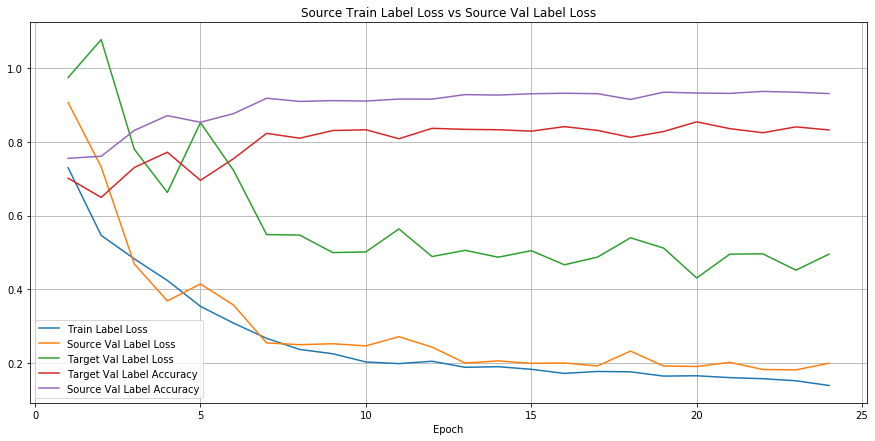

In [16]:
ax = get_loss_curve(experiment)
plt.show()

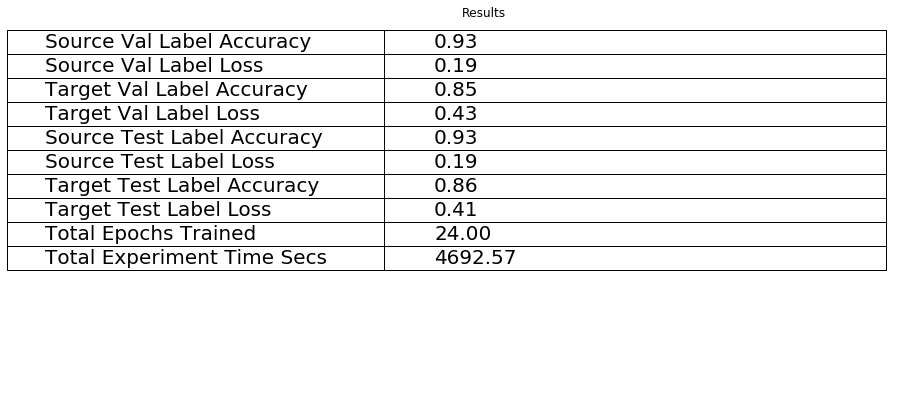

In [17]:
get_results_table(experiment)

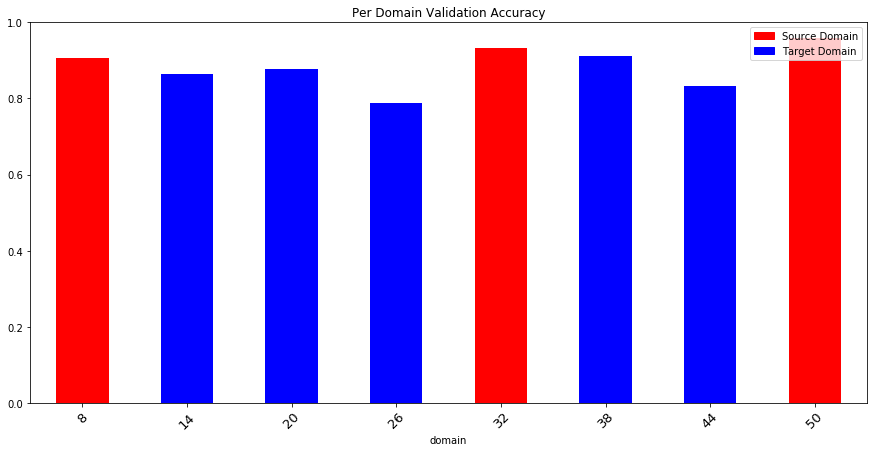

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9342013888888889 Target Test Label Accuracy: 0.8578125
Source Val Label Accuracy: 0.9328125 Target Val Label Accuracy: 0.8545833333333334


In [20]:
json.dumps(experiment)

'{"experiment_name": "baseline_ptn_oracle.run1.framed", "parameters": {"experiment_name": "baseline_ptn_oracle.run1.framed", "lr": 0.001, "device": "cuda", "seed": 1337, "dataset_seed": 1337, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "x_transforms_source": [], "x_transforms_target": [], "episode_transforms_source": [], "episode_transforms_target": [], "num_examples_per_domain_per_label_source": 1000, "num_examples_per_domain_per_label_target": 1000, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 1, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float64", "n_epoch": 50, "patience": 3, "criteria_for_best": "target